In [1]:
# mounring drive
from google.colab import drive
drive.mount('/content/drive')

# installing *padas-profilin* from github
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip --quiet

!pip install --upgrade keras-cv --quiet
!pip install --upgrade keras --quiet
!pip install --upgrade tensorflow --quiet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Preparing metadata (setup.py) ... done


In [2]:
# imports
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import os
from pathlib import Path
import shutil
from PIL import Image

import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np

import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics

import keras_cv

# Import tensorflow for [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds

print(keras.__version__)
print(keras_cv.__version__)

<ipython-input-2-c286deb14e73>:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


3.5.0
0.9.0


In [3]:
def find(dir_, str):
  for each in dir(dir_):
    if str in each:
      print(each)

In [4]:
#@title loading data from mounted drive
train_ = pd.read_csv('/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/Train-Data.csv')
test_ = pd.read_csv('/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/Test-Data.csv')

In [5]:
#@title statestical analysis

# profile = ProfileReport(train_)
# profile.to_file(output_file='training_profiling.html')
# # profile = ProfileReport(test_)
# # profile.to_file(output_file='testing_profiling.html')

In [6]:
#@title Moving all images of all query to one folder - all_images

def move_images(to_, from_):
  # create destination folder
  destination_folder = to_
  # delete destination folder if it exist
  if os.path.exists(destination_folder):
    shutil.rmtree(destination_folder)
  # create destination folder
  os.makedirs(destination_folder)

  for i in Path(from_).iterdir():
    for _ in i.iterdir():  # i.iterdir() is iterating over all directories in "Image-Files"
      path = _    # _ = /content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/Image-Files/street litter/5452da10-679d-11e5-90f4-40f2e96c8ad8.jpg
      filename = os.path.basename(path)

      source_path = path
      destination_path = os.path.join(destination_folder, filename)
      shutil.copy(source_path, destination_folder)

to_ = '/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/all_images'
from_ = '/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/Image-Files/'
move_images(to_, from_)

In [7]:
#@title generalizing the type of image - for that finding the total unique image extentions present
def find_extentions(path):      # finds the number of different extentions are there in the given directory
  extentions = {}
  for i in Path(path).iterdir():
    if i.suffix not in extentions:
      extentions[i.suffix] = 1
    else:
      extentions[i.suffix] += 1
  # sum of value of each key
  print(sum(extentions.values()))
  return extentions

path = '/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/all_images'
find_extentions(path)

907


{'.jpg': 833,
 '.jpeg': 5,
 '.JPG': 42,
 '.gif': 9,
 '.png': 16,
 '.JPEG': 1,
 '.php': 1}

In [8]:
#@title generalizing the type of image - deleting .php file & convering others to .jpg

def rename_files(path): # deletes .php files and remaning every other.
  for i in Path(path).iterdir():
    suffix = i.suffix # suffix = file extention i.e. ".jpg"
    without_extention = os.path.splitext(i)[0]
    # withoug_extention = # /content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/
    # all_images/5452da10-679d-11e5-90f4-40f2e96c8ad8

    if len(os.path.splitext(without_extention)) >=2:            # if there are morethan 1 "." the os.path.splitext()[0] takes only first part before the dot and adds the suffix in the end.
      os.rename(i, os.path.splitext(without_extention)[0]+suffix)  # to remove and generalize the name of the image for next step of moving data as per the labels

    if suffix == '.jpg':
      pass
    elif suffix == '.jpeg' or suffix == '.JPG' or suffix == '.JPEG':
      os.rename(i, without_extention+'.jpg')
    elif suffix == '.png':
      png_image = Image.open(i)
      # converting .png to .jpg using PLI library
      rgb_image = png_image.convert("RGB")

      # Save the image as a JPEG
      rgb_image.save(without_extention+'.jpg', quality=95)
      # remove/delete file
      os.remove(i)
    elif suffix == '.gif':
      gif_image = Image.open(i)
      # converting .gif to .jpg using PLI library and saving in '/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/all_images' folder
      rgb_image = gif_image.convert("RGB")

      # Save the image as a JPEG
      rgb_image.save(without_extention+'.jpg', quality=95)
      # remove/delete file
      os.remove(i)
    else:                                     # .php files
      # remove/delete file
      os.remove(i)

path = '/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/all_images'
rename_files(path)

In [9]:
#@title generalizing the type of image - final check that all the images in *all_images* folder is of *.jpg* type
#@markdown there are 906 files because the *.php* file is removed.

path = '/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/all_images'
find_extentions(path)

906


{'.jpg': 906}

In [10]:
#@title movind the image data according to their labels
#markdown In this approach I am considering the all *none* labelled images as *0* labelled.

def find_labels(dataFrame_):
  label_1=[]
  label_0=[]

  for each in dataFrame_.iterrows():

    filename = Path(each[1].image)
    without_extention = os.path.splitext(filename)[0]

    if filename.suffix == '.php':                   # don't add .php file, because we have removed it.
      continue

    if each[1].label == 1:
      label_1.append(without_extention+'.jpg')
    else:
      label_0.append(without_extention+'.jpg')

  print(len(label_1))
  print(len(label_0))
  print(f'sum = {len(label_1) + len(label_0)}')      # the sum should be 906

  return label_1, label_0

In [11]:

# prompt: put all images with image id in list "label_1" in folder label-1 and list "label_0" in label-0 folder from this folder - '/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/Image-Files'

def move_images_as_per_labels(source_folder, destination_folder_1, destination_folder_0, label_1, label_0):

  # delete them if they already exist & Create destination folders if they don't exist
  if os.path.exists(destination_folder_1):
    shutil.rmtree(destination_folder_1)
  if os.path.exists(destination_folder_0):
    shutil.rmtree(destination_folder_0)
  os.makedirs(destination_folder_1, exist_ok=True)
  os.makedirs(destination_folder_0, exist_ok=True)

  # Move files for label 1
  for image_id in label_1:
    filename = image_id   # Assuming images are in JPG format
    source_path = os.path.join(source_folder, filename)
    destination_path = os.path.join(destination_folder_1, filename)
    shutil.copy(source_path, destination_path)

  # Move files for label 0
  for image_id in label_0:
    filename = image_id  # Assuming images are in JPG format
    source_path = os.path.join(source_folder, filename)
    destination_path = os.path.join(destination_folder_0, filename)
    shutil.copy(source_path, destination_path)

In [12]:

train_label_1, train_label_0 = find_labels(train_)

source_folder = '/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/all_images'
destination_folder_1 = '/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/train_labelled/label-1'
destination_folder_0 = '/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/train_labelled/label-0'

move_images_as_per_labels(source_folder, destination_folder_1, destination_folder_0, label_1 = train_label_1, label_0 = train_label_0)



test_label_1, test_label_0 = find_labels(test_)
source_folder = '/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/all_images'
destination_folder_1 = '/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/test_labelled/label-1'
destination_folder_0 = '/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/test_labelled/label-0'

move_images_as_per_labels(source_folder, destination_folder_1, destination_folder_0, label_1 = test_label_1, label_0 = test_label_0)

337
569
sum = 906
43
17
sum = 60


In [13]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/train_labelled',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    seed=46,
    shuffle=True,
)

test_ds = keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/test_labelled',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    seed=46,
    shuffle=True,
)

Found 906 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


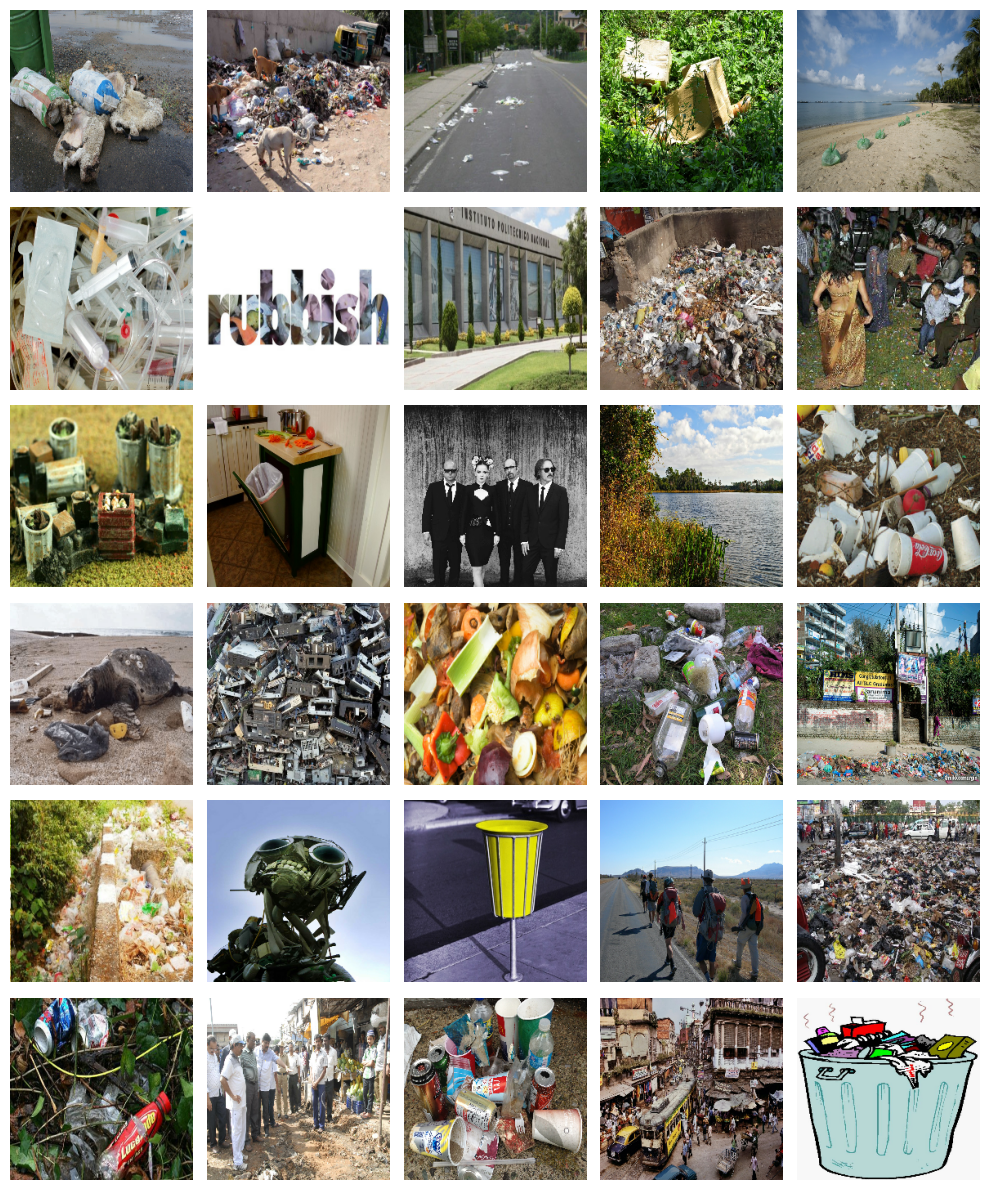

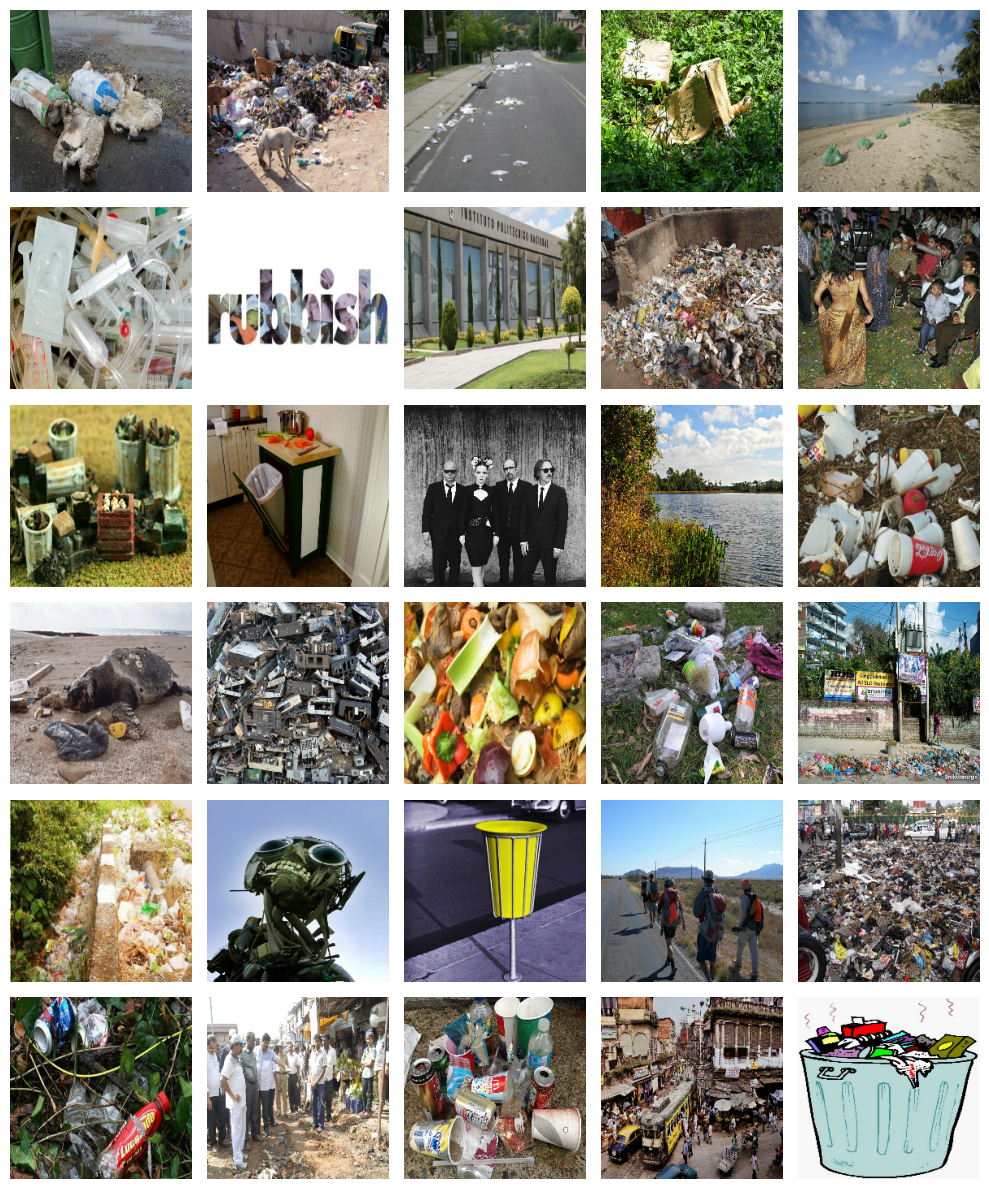

In [14]:
images = next(iter(train_ds.take(1)))[0]
keras_cv.visualization.plot_image_gallery(images, value_range=(0, 255))

# EfficientNEt

In [15]:
# @title #BASELINE MODEL - efficientnetv2 pretrained on imagenet

# https://keras.io/api/keras_cv/models/

model = keras_cv.models.ImageClassifier.from_preset(
    "efficientnetv2_b0_imagenet", num_classes=2,
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["f1_score"],
)

model.summary()

Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficient_net_v2b0_backbone          │ (None, None, None, 1280)    │       5,919,312 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,921,874 (22.59 MB)

 Trainable params: 5,861,266 (22.36 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [16]:
'''title score on baseline model - {'f1_score': Array([0.4313725 , 0.57971007], dtype=float32),
 'loss': 0.6963793635368347}'''

model.evaluate(test_ds)
model.get_metrics_result()

2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 17s/step - f1_score: 0.4545 - loss: 0.7316


{'f1_score': Array([0.41379303, 0.45161286], dtype=float32),
 'loss': 0.7330372929573059}

In [17]:
# @title Training model
# @markdown Epoch 1/2
# @markdown 29/29 ━━━━━━━━━━━━━━━━━━━━ 314s 9s/step - accuracy: 0.5956 - loss: 0.6283 - val_accuracy: 0.7833 - val_loss: 0.4634
# @markdown Epoch 2/2
# @markdown 29/29 ━━━━━━━━━━━━━━━━━━━━ 230s 8s/step - accuracy: 0.7876 - loss: 0.4687 - val_accuracy: 0.8667 - val_loss: 0.3168
# @markdown <keras.src.callbacks.history.History at 0x780c0243cd30>

In [18]:
model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1689s 54s/step - f1_score: 0.5414 - loss: 0.6344 - val_f1_score: 0.8460 - val_loss: 0.4185
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1504s 47s/step - f1_score: 0.7884 - loss: 0.4625 - val_f1_score: 0.9230 - val_loss: 0.2800
Epoch 3/5
 6/29 ━━━━━━━━━━━━━━━━━━━━ 17:04 45s/step - f1_score: 0.8828 - loss: 0.2911

Exception ignored in: <function _xla_gc_callback at 0x79ab3b34a680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


29/29 ━━━━━━━━━━━━━━━━━━━━ 1310s 45s/step - f1_score: 0.8834 - loss: 0.2862 - val_f1_score: 0.9798 - val_loss: 0.0733
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1390s 48s/step - f1_score: 0.9087 - loss: 0.2009 - val_f1_score: 0.9603 - val_loss: 0.1356
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1321s 46s/step - f1_score: 0.9351 - loss: 0.1633 - val_f1_score: 0.9603 - val_loss: 0.0611


In [20]:
import datetime
time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
time_ = time
model.save(f'/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/trained_efficientnetv2_b0_imagenet_{time_}.keras')

In [21]:
# @title loading model
model = keras.models.load_model(f'/content/drive/MyDrive/DLCV project/Smart Waste Management in Modern Cities/trained_efficientnetv2_b0_imagenet_{time_}.keras')

In [22]:
model.summary()

Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficient_net_v2b0_backbone          │ (None, None, None, 1280)    │       5,919,312 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,644,408 (67.31 MB)

 Trainable params: 5,861,266 (22.36 MB)

 Non-trainable params: 60,608 (236.75 KB)

 Optimizer params: 11,722,534 (44.72 MB)

In [23]:
find(model, 'lay')

_flatten_layers
_functional_layer_ids
_layers
get_layer
layers


In [24]:
model._layers

[<InputLayer name=input_layer_1, built=True>,
 <EfficientNetV2Backbone name=efficient_net_v2b0_backbone, built=True>,
 <GlobalAveragePooling2D name=avg_pool, built=True>,
 <Dense name=predictions, built=True>]

In [25]:
model.layers

[<InputLayer name=input_layer_1, built=True>,
 <EfficientNetV2Backbone name=efficient_net_v2b0_backbone, built=True>,
 <GlobalAveragePooling2D name=avg_pool, built=True>,
 <Dense name=predictions, built=True>]

In [26]:
model.layers[1].summary()

Model: "efficient_net_v2b0_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stem_conv (Conv2D)                   │ (None, None, None, 32)      │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stem_bn (BatchNormalization)         │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stem_activation (Activation)         │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1a_ (FusedMBConvBlock)          │ (None, None, None, 16)      │           4,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2a_ (FusedMBConvBlock)          │ (None, None, None, 32)      │          11,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2b_ (FusedMBConvBlock)          │ (None, None, None, 32)      │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3a_ (FusedMBConvBlock)          │ (None, None, None, 48)      │          43,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3b_ (FusedMBConvBlock)          │ (None, None, None, 48)      │          93,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4a_ (MBConvBlock)               │ (None, None, None, 96)      │          36,108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4b_ (MBConvBlock)               │ (None, None, None, 96)      │          99,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4c_ (MBConvBlock)               │ (None, None, None, 96)      │          99,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5a_ (MBConvBlock)               │ (None, None, None, 112)     │         158,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5b_ (MBConvBlock)               │ (None, None, None, 112)     │         200,732 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5c_ (MBConvBlock)               │ (None, None, None, 112)     │         200,732 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5d_ (MBConvBlock)               │ (None, None, None, 112)     │         200,732 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5e_ (MBConvBlock)               │ (None, None, None, 112)     │         200,732 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block6a_ (MBConvBlock)               │ (None, None, None, 192)     │         254,812 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block6b_ (MBConvBlock)               │ (None, None, None, 192)     │         574,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block6c_ (MBConvBlock)               │ (None, None, None, 192)     │         574,512 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,858,704 (22.35 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [27]:
model.layers[1].layers

[<InputLayer name=input_layer_1, built=True>,
 <Rescaling name=rescaling_1, built=True>,
 <Conv2D name=stem_conv, built=True>,
 <BatchNormalization name=stem_bn, built=True>,
 <Activation name=stem_activation, built=True>,
 <FusedMBConvBlock name=block1a_, built=True>,
 <FusedMBConvBlock name=block2a_, built=True>,
 <FusedMBConvBlock name=block2b_, built=True>,
 <FusedMBConvBlock name=block3a_, built=True>,
 <FusedMBConvBlock name=block3b_, built=True>,
 <MBConvBlock name=block4a_, built=True>,
 <MBConvBlock name=block4b_, built=True>,
 <MBConvBlock name=block4c_, built=True>,
 <MBConvBlock name=block5a_, built=True>,
 <MBConvBlock name=block5b_, built=True>,
 <MBConvBlock name=block5c_, built=True>,
 <MBConvBlock name=block5d_, built=True>,
 <MBConvBlock name=block5e_, built=True>,
 <MBConvBlock name=block6a_, built=True>,
 <MBConvBlock name=block6b_, built=True>,
 <MBConvBlock name=block6c_, built=True>,
 <MBConvBlock name=block6d_, built=True>,
 <MBConvBlock name=block6e_, built=Tru

In [28]:
# model.layers[1].layers[11].

In [29]:
#calculate f1 score
model.evaluate(test_ds, return_dict=True)
model.get_metrics_result()  #0.96, 0.04

2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 17s/step - f1_score: 0.9622 - loss: 0.0547


{'f1_score': Array([0.9444444, 0.9761904], dtype=float32),
 'loss': 0.06112569570541382}

In [30]:
# prompt: show all test images with their original label and predicted label

import numpy as np
import matplotlib.pyplot as plt

# Assuming your test_ds is a tf.data.Dataset
y_true = []
y_pred = []
images_list = []

for images, labels in test_ds:
  y_true.extend(np.argmax(labels.numpy(), axis=1))  # Get true labels
  predictions = model.predict(images)
  y_pred.extend(np.argmax(predictions, axis=1))  # Get predicted labels
  images_list.extend(images.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


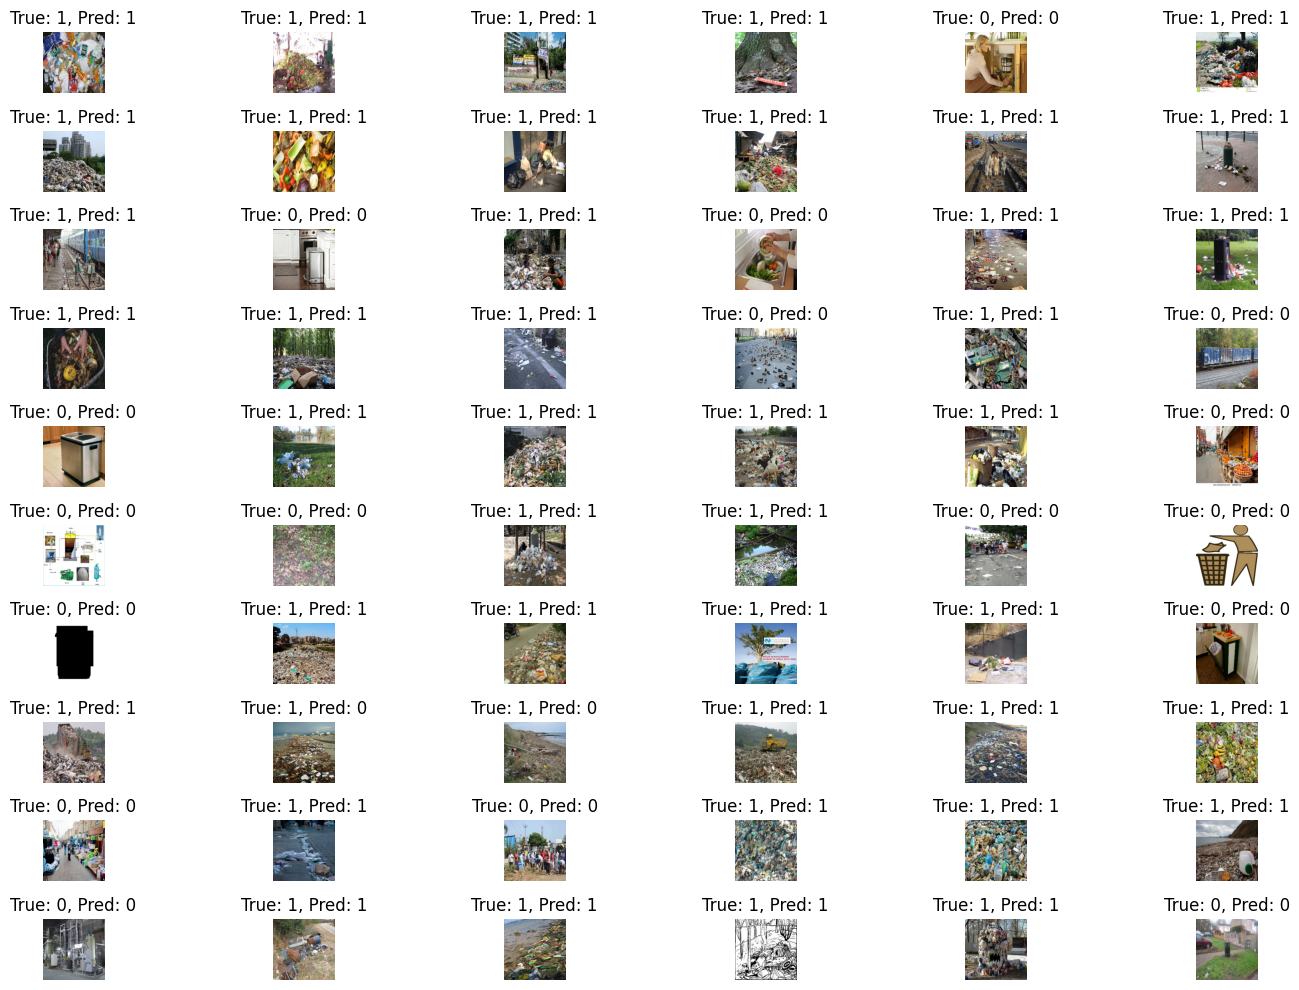

In [31]:

# Display images with labels
plt.figure(figsize=(15,10))
for i in range(len(images_list)):
  plt.subplot(10, 6, i+1)  # Adjust grid as needed
  plt.imshow(images_list[i].astype("uint8"))
  plt.title(f"True: {y_true[i]}, Pred: {y_pred[i]}")
  plt.axis("off")
plt.tight_layout()
plt.show()

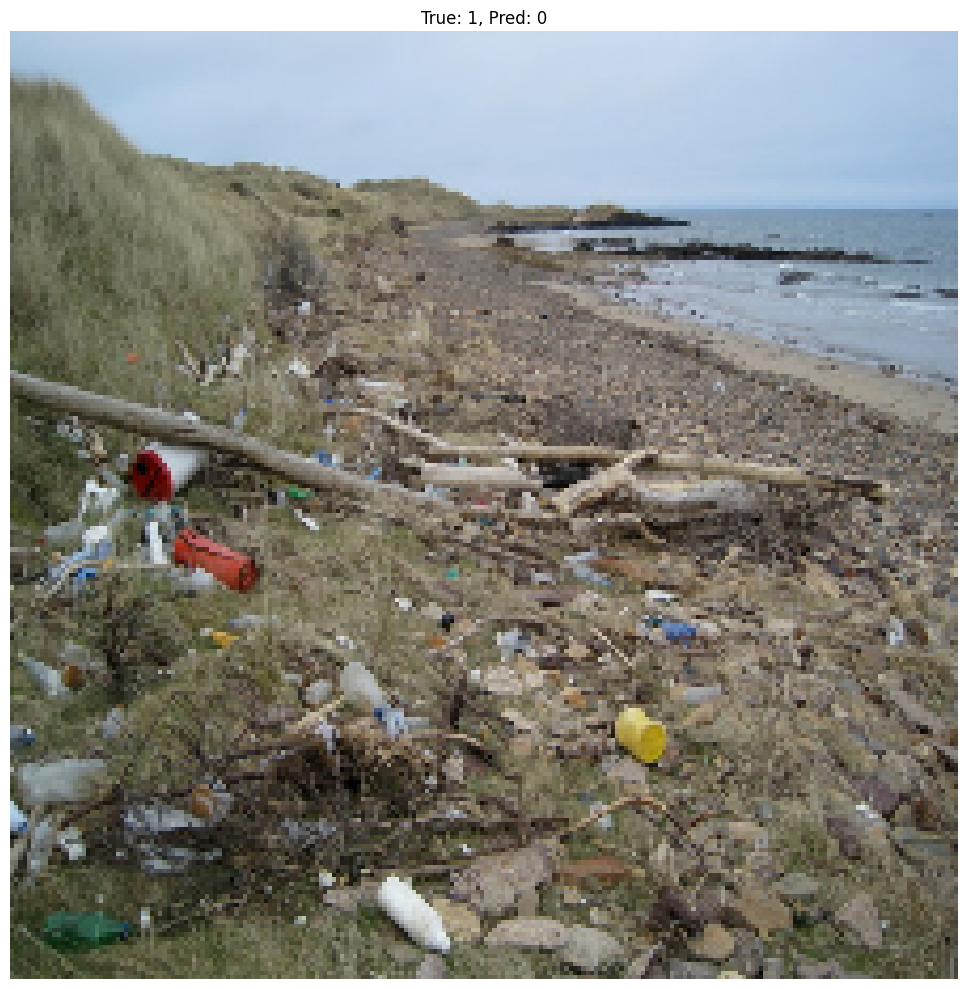

In [32]:
plt.figure(figsize=(15,10))
for i in range(len(images_list)):
  if y_true[i] == y_pred[i]:
    continue
  # plt.subplot(10, 6, i+1)  # Adjust grid as needed
  # do not show if y_true != y_pred
  plt.imshow(images_list[i].astype("uint8"))
  plt.title(f"True: {y_true[i]}, Pred: {y_pred[i]}")
  plt.axis("off")
plt.tight_layout()
plt.show()

In [33]:
# @title #BASELINE MODEL - efficientnetv2 pretrained on imagenet

# https://keras.io/api/keras_cv/models/

resnet50v2__ = keras_cv.models.ImageClassifier.from_preset(
    'resnet50_v2_imagenet', num_classes=2,
)

# model = keras_cv.models.EfficientNetV2.from_preset(
#     "efficientnetv2_b0_imagenet", num_classes=2,
# )
resnet50v2__.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["f1_score"],
)

resnet50v2__.summary()

Model: "image_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net50v2_backbone                 │ (None, None, None, 2048)    │      23,564,800 │
│ (ResNetV2Backbone)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_pool (GlobalAveragePooling2D)    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,568,898 (89.91 MB)

 Trainable params: 23,523,458 (89.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [34]:
resnet50v2__.evaluate(test_ds)
resnet50v2__.get_metrics_result()

2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 20s/step - f1_score: 0.2374 - loss: 0.9063


{'f1_score': Array([0.44736838, 0.04545454], dtype=float32),
 'loss': 0.8987383246421814}

In [35]:
resnet50v2__.layers[1].summary()

Model: "res_net50v2_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, None, None, 3)  │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ rescaling_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v2_stack_0_block1_use_pr… │ (None, None, None, 64) │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v2_stack_0_block1_use_pr… │ (None, None, None, 64) │              0 │ v2_stack_0_block1_use… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v2_stack_0_block1_1_conv  │ (None, None, None, 64) │          4,096 │ v2_stack_0_block1_use… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v2_stack_0_block1_1_bn    │ (None, None, None, 64) │            256 │ v2_stack_0_block1_1_c… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v2_stack_0_block1_1_relu  │ (None, None, None, 64) │              0 │ v2_stack_0_block1_1_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v2_stack_0_block1_2_conv  │ (None, None, None, 64) │         36,864 │ v2_stack_0_block1_1_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v2_stack_0_block1_2_bn    │ (None, None, None, 64) │            256 │ v2_stack_0_block1_2_c… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v2_stack_0_block1_2_relu  │ (None, None, None, 64) │              0 │ v2_stack_0_block1_2_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v2_stack_0_block1_0_conv  │ (None, None, None,     │         16,640 │ v2_stack_0_block1_use… │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ v2_stack_0_block1_3_conv  │ (None, None, None,     │         16,640 │ v2_stack_0_block1_2_r… │
│ (Conv2D)                  │ 256)                   │                │                        │
├──────────────────────

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
resnet50v2__.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 3040s 103s/step - f1_score: 0.5449 - loss: 0.6282 - val_f1_score: 0.7068 - val_loss: 0.5959
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 2907s 98s/step - f1_score: 0.7089 - loss: 0.5060 - val_f1_score: 0.2208 - val_loss: 3.2618
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 2905s 100s/step - f1_score: 0.7561 - loss: 0.4631 - val_f1_score: 0.2949 - val_loss: 2.1502
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 2906s 100s/step - f1_score: 0.7871 - loss: 0.3880 - val_f1_score: 0.8168 - val_loss: 0.4762
Epoch 5/5
16/29 ━━━━━━━━━━━━━━━━━━━━ 21:21 99s/step - f1_score: 0.8113 - loss: 0.3372

In [ ]:
from keras import layers
# the model architecture is taken from https://keras.io/guides/functional_api/
inputs = keras.Input(shape=(224, 224, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output])
m.
x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(256, activation="softmax")(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [ ]:
if True:
  model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
)